In [1]:
import numpy as np
import numpy.random as nrd
import numpy.linalg as nla

import matplotlib.pyplot as plt

from SOM import SelfOrganizingMaps
from sklearn.cluster import KMeans

# Exercise 14.5

Generate data with three features, with 30 data points in each of
three classes as shown below in the notebook - the data
lie near the surface of a sphere in three clusters centered at (1, 0, 0), (0, 1, 0)
and (0, 0, 1).

Write a program to fit a SOM to these data, using the learning rates
given in the text. Carry out a K-means clustering of the same data, and
compare the results to those in the text.

# Solution

Data generation,

In [2]:
# Generate point on the hemisphere
def points(theta,phi,W):
    
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    return np.hstack((x,y,z)) + W

# Generate the data for this specific exercise
def data(N,noise=0.6,random_seed=0):
    
    rng =  nrd.default_rng(seed=random_seed)

    # Class 1
    theta1 = (np.pi/4)*rng.random((N,1)) - np.pi/8
    phi1 = (2*np.pi)*rng.random((N,1))
    W1 = rng.normal(scale=noise,size=(N,3))
    
    X1 = points(theta1,phi1,W1)
    y1 = np.full(N,1)
    
    # Class 2
    theta2 = (np.pi/2)*(1/2 + rng.random((N,1)))
    phi2 = (np.pi/2)*rng.random((N,1)) - np.pi/4
    W2 = rng.normal(scale=noise,size=(N,3))
    
    X2 = points(theta2,phi2,W2)
    y2 = np.full(N,2)
    
    # Class 3
    theta3 = (np.pi/2)*(1/2 + rng.random((N,1)))
    phi3 = (np.pi/2)*(1/2 + rng.random((N,1)))
    W3 = rng.normal(scale=noise,size=(N,3))
    
    X3 = points(theta3,phi3,W3)
    y3 = np.full(N,3)
    
    X = np.vstack((X1,X2,X3))
    y = np.concatenate((y1,y2,y3))
    
    return X,y

Let us visualize the data,

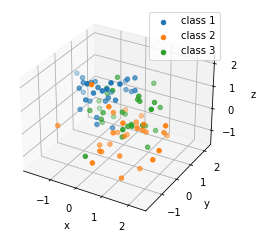

In [3]:
# Observations per class
N_cls = 30
X,y = data(N_cls)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for cls in range(1,4):
    X_cls = X[y == cls]
    ax.scatter(X_cls[:,0], X_cls[:,1], X_cls[:,2],label='class {}'.format(cls))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()

### Self-Organizing Map

Let us create an instance of the SOM model,

In [4]:
# Number of prototypes per direction
grid_size = (5,5)

# Hyperplane dimension for SOM model
q = 2

model = SelfOrganizingMaps(grid_size,q)
model.initialize_prototypes(X)

Since the SOM initialize the prototypes onto the q-dimensional (q=2 in general) principal hyperplane, we plot that hyperplane here, and we show the lattice formed by the initial prototypes,

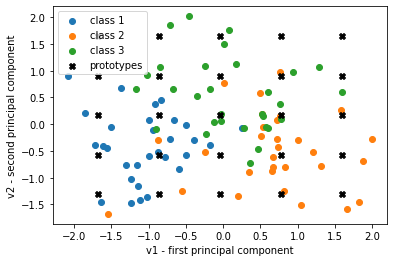

In [5]:
N,p = X.shape

# Get SVD for the data
X_mean = np.mean(X,axis=0)
U,D,Vt = nla.svd(X-X_mean)

# Get the prototypes position
prototypes = np.array(list(model.prototypes.values()))
K,_ = prototypes.shape

# Project data and prototypes in the q-dimensional hyperplane (q = 2 here)
proj = np.empty(shape=(N,0))
proj_proto = np.empty(shape=(K,0))
for i in range(q):
    # Principal component for the data
    pc = U[:,i] * D[i] + X_mean @ Vt[i] 
    proj = np.hstack((proj,pc.reshape((N,1))))
    
    # Principal component for the prototypes
    pc_proto = prototypes @ Vt[i]
    proj_proto = np.hstack((proj_proto,pc_proto.reshape((K,1))))

# Plot the data
for cls in range(1,4):
    pj_cls = proj[y==cls]
    plt.scatter(pj_cls[:,0],pj_cls[:,1],label='class {}'.format(cls))

# Plot the initial prototypes
plt.scatter(proj_proto[:,0],proj_proto[:,1],marker='X',c='black',label='prototypes')

plt.xlabel('v1 - first principal component')
plt.ylabel('v2 - second principal component')
plt.legend()
plt.show()

We can now train the model,

In [6]:
# Number of iterations for the training
epochs = 100
iterations = epochs*N

# Parameter of the model
alpha = 1.
r = 2.

model.fit(X,iterations,alpha,r)

To compare the reconstruction error of SOM with K-means, let's first define

In [7]:
# Compute the reconstruction error for the model
def reconstruction_error_Kmeans(X,centroids):

    N,_ = X.shape

    # Compute distance of each observation from the prototypes
    distances = np.empty((N,0))
    for m in centroids:
        dist_m = np.sum((X-m)**2,axis=1)
        distances = np.hstack((distances,dist_m.reshape((N,1))))

    # Sum the minimum distance for each observation
    error = np.sum(np.min(distances,axis=1))

    return error

K-means gives,

In [8]:
# We use same number of clusters as SOM
K = 25

kmeans = KMeans(n_clusters=K)
kmeans.fit(X)
centroids = kmeans.cluster_centers_

Kmeans_error = reconstruction_error_Kmeans(X,centroids)

Let's visualize the reconstruction error,

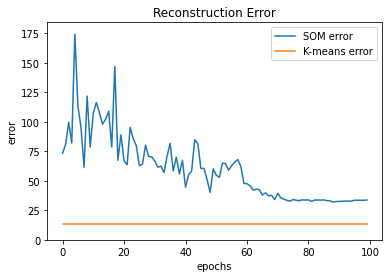

In [9]:
SOM_error = model.learning_curve

plt.plot(SOM_error,label='SOM error')
plt.plot([Kmeans_error]*epochs,label='K-means error')
plt.title('Reconstruction Error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.ylim([0,max(SOM_error)+10])
plt.legend()
plt.show()

Let us also visualize what the clusters are containing for our dataset (using similar technique as in main text, Fig 14.16,

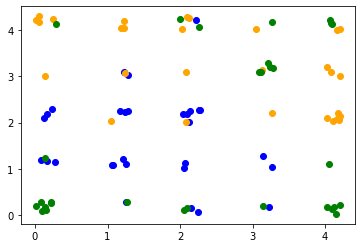

In [10]:
clusters_SOM = model.cluster(X,y)

eps = 3e-1
colours = ['blue','orange','green']

for i in range(5):
    for j in range(5):
        for el in clusters_SOM[i,j]:
            mx = i+eps*nrd.rand()
            my = j+eps*nrd.rand()
            plt.scatter(mx,my,c=colours[el-1])
            
plt.show()     